In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
from scipy.stats import nbinom
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES


In [148]:
# toy example
hosp = np.array([np.array([90, 96]), np.array([105, 110])])
case = np.array([np.array([950, 1001]), np.array([110, 103])])
death = np.array([np.array([5,6]), np.array([12,9])])

X1 = np.array([hosp[0], case[0], death[0]])
X2 = np.array([hosp[1], case[1], death[1]])
A = np.array([X1, X2])

obsh = np.array([100, 103])
obsc = np.array([1000, 999])
obsd = np.array([10, 11])

obs = np.array([obsh, obsc, obsd])
X = np.array([hosp, case, death])

In [147]:
energyscore_multipletargets(A, obs)

0.6276617436085661

# Flu SMH

In [4]:
def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters  
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions


In [5]:
# surveillance data

#deaths
deaths = pd.read_csv('../fludat/National_2023-24_Data.csv').drop(columns=['SUB AREA', 'AGE GROUP', 
                                                                    'PERCENT COMPLETE', 'TOTAL DEATHS'])

deaths['YEAR'] = deaths['WEEK'].apply(lambda key: 2023 if key>=30 else 2024)
deaths['date'] = deaths['WEEK'].apply(lambda key: Week(2023, key).enddate() if key>=30 else Week(2024, 
                                                                                         key).enddate())

deaths = deaths[deaths.date<=pd.to_datetime('2024-04-27')]


#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.location=='US') & (hosp.date>=pd.to_datetime('2023-10-01'))].sort_values(by=['date']).drop(columns=\
                                                                               'Unnamed: 0').reset_index()



In [6]:
# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(hosp.date.max())




predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pull_flu_scenario_modeling_hub_predictions(model,'2023-09-03')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    
    numweeks = list(df.horizon.unique())
    start_date = list(df.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates}) # add date of prediction to dataframe
    df = df.merge(dfdates, how='inner', on='horizon')

    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
    



In [27]:
predictionsUS = predictionsall[predictionsall.location=='US']
predictionsUS = predictionsUS[~predictionsUS['Model'].isin(['NIH-Flu_TS', 'PSI-M2'])]

In [194]:
predictionsUS

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,trajectory_id,target_end_date
0,2023-09-03,A-2023-08-14,inc hosp,1.0,US,sample,1,0-130,16.169202,CDDEP-FluCompModel,101,2023-09-09
1,2023-09-03,A-2023-08-14,inc hosp,1.0,US,sample,2,0-130,16.247223,CDDEP-FluCompModel,102,2023-09-09
2,2023-09-03,A-2023-08-14,inc hosp,1.0,US,sample,3,0-130,16.334192,CDDEP-FluCompModel,103,2023-09-09
3,2023-09-03,A-2023-08-14,inc hosp,1.0,US,sample,4,0-130,15.643527,CDDEP-FluCompModel,104,2023-09-09
4,2023-09-03,A-2023-08-14,inc hosp,1.0,US,sample,5,0-130,15.619743,CDDEP-FluCompModel,105,2023-09-09
...,...,...,...,...,...,...,...,...,...,...,...,...
40795,2023-09-03,F-2023-08-14,inc death,34.0,US,sample,96,0-130,11.343005,UVA-FluXSim,996,2024-04-27
40796,2023-09-03,F-2023-08-14,inc death,34.0,US,sample,97,0-130,4.754075,UVA-FluXSim,997,2024-04-27
40797,2023-09-03,F-2023-08-14,inc death,34.0,US,sample,98,0-130,9.913824,UVA-FluXSim,998,2024-04-27
40798,2023-09-03,F-2023-08-14,inc death,34.0,US,sample,99,0-130,10.504833,UVA-FluXSim,999,2024-04-27


In [28]:
h = np.array(hosp['value'])
d = np.array(deaths['NUM INFLUENZA DEATHS'])
obs = np.array([h,d])

In [19]:
list(predictionsUS.Model.unique())+['Trajectory Ensemble']

['CDDEP-FluCompModel',
 'MOBS_NEU-GLEAM_FLU',
 'NIH-FluD',
 'NIH-Flu_TS',
 'NotreDame-FRED',
 'PSI-M2',
 'USC-SIkJalpha',
 'UT-ImmunoSEIRS',
 'UVA-FluXSim',
 'Trajectory Ensemble']

In [29]:

energyscores_mt = pd.DataFrame()
for model in list(predictionsUS.Model.unique())+['Trajectory Ensemble']:
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        if model in ['NIH-Flu_TS', 'PSI-M2']:
            continue
        elif model in ['Trajectory Ensemble']:
            predictionshosp = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.target == 'inc hosp')  ]

            Xhosp = [np.array(predictionshosp[predictionshosp.trajectory_id == i].value) for \
                     i in predictionshosp.trajectory_id.unique()]

            predictionsdeath = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.target == 'inc death')  ]


            Xdeath = [np.array(predictionsdeath[predictionsdeath.trajectory_id == i].value) for \
                     i in predictionsdeath.trajectory_id.unique()]
            
        else:

            predictionshosp = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.Model == model) &\
                                        (predictionsUS.target == 'inc hosp')  ]

            Xhosp = [np.array(predictionshosp[predictionshosp.trajectory_id == i].value) for \
                     i in predictionshosp.trajectory_id.unique()]

            predictionsdeath = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.Model == model) &\
                                        (predictionsUS.target == 'inc death')  ]


            Xdeath = [np.array(predictionsdeath[predictionsdeath.trajectory_id == i].value) for \
                     i in predictionsdeath.trajectory_id.unique()]

        
        A = []

        for i in range(len(Xhosp)):
            Ai = np.array([Xhosp[i], Xdeath[i]])
            A.append(Ai)

        A = np.array(A)

        ES = energyscore_multipletargets(A,obs)


        newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                             'energyscore': ES}, index=[0])

        energyscores_mt = pd.concat([energyscores_mt, newrow])

energyscores_mt = energyscores_mt.reset_index().drop(columns=['index'])   


In [30]:
energyscores_mt

,Model,Label,location,energyscore
0,CDDEP-FluCompModel,Scenario A,US,8.443649
1,CDDEP-FluCompModel,Scenario B,US,6.281090
2,CDDEP-FluCompModel,Scenario C,US,9.182394
3,CDDEP-FluCompModel,Scenario D,US,7.318083
4,CDDEP-FluCompModel,Scenario E,US,10.853808
5,CDDEP-FluCompModel,Scenario F,US,8.311735
6,MOBS_NEU-GLEAM_FLU,Scenario A,US,4.504183
7,MOBS_NEU-GLEAM_FLU,Scenario B,US,5.616052
8,MOBS_NEU-GLEAM_FLU,Scenario C,US,4.640874
9,MOBS_NEU-GLEAM_FLU,Scenario D,US,4.937574


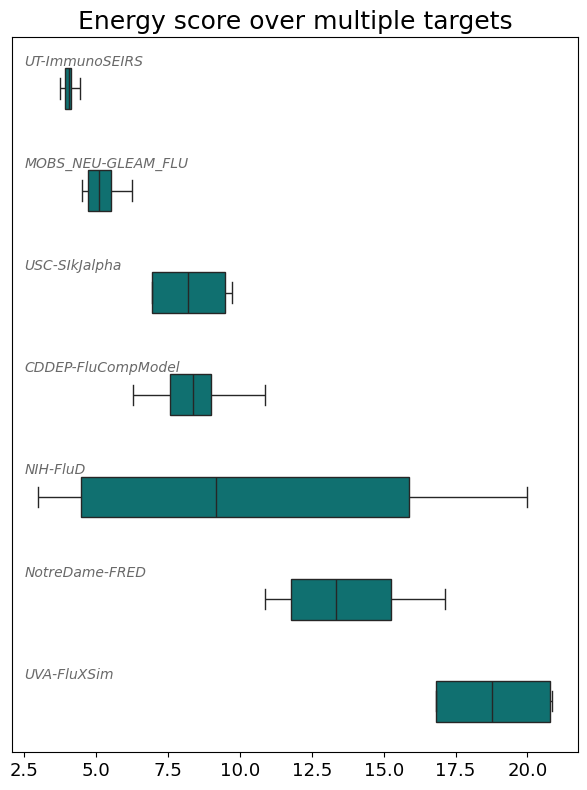

In [305]:
plt.subplots(1,1,figsize=(6,8))
i=1



df = energyscores_mt.copy()


my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index

ges = sns.boxplot(x='energyscore', y='Model', data=df, order = my_order, color = 'teal', width=0.4)

ges.set(yticklabels=[])
ges.set(yticks=[])

if i in [1, 3,5]:
    plt.ylabel('', fontsize=15)
else:
    ges.set(ylabel=None)    

if i in [5,6]:
    plt.xlabel('Energy score', fontsize=14)
else:
    ges.set(xlabel=None)


a = 0
for mod in list(my_order):
    plt.text(2.5,a-.22, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.title('Energy score over multiple targets', fontsize=18)
plt.tight_layout()
#plt.savefig('standardrank_energyscore.pdf')
plt.show()


In [31]:
obs = np.array(hosp['value'])

energyscores_hosp = pd.DataFrame()
for model in list(predictionsUS.Model.unique())+['Trajectory Ensemble']:
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        if model in ['NIH-Flu_TS', 'PSI-M2']:
            continue
        elif model in ['Trajectory Ensemble']:
            predictionshosp = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.target == 'inc hosp')  ]

            Xhosp = [np.array(predictionshosp[predictionshosp.trajectory_id == i].value) for \
                     i in predictionshosp.trajectory_id.unique()]
            
        else:

            predictionshosp = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.Model == model) &\
                                        (predictionsUS.target == 'inc hosp')  ]

            Xhosp = [np.array(predictionshosp[predictionshosp.trajectory_id == i].value) for \
                     i in predictionshosp.trajectory_id.unique()]

        A = np.array(Xhosp)

        ES = energyscore_multipletargets(A,obs)


        newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                             'energyscore': ES, 'target':'hosp'}, index=[0])

        energyscores_hosp = pd.concat([energyscores_hosp, newrow])

energyscores_hosp = energyscores_hosp.reset_index().drop(columns=['index'])   


In [32]:
obs = np.array(deaths['NUM INFLUENZA DEATHS'])

energyscores_death = pd.DataFrame()
for model in list(predictionsUS.Model.unique())+['Trajectory Ensemble']:
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        if model in ['NIH-Flu_TS', 'PSI-M2']:
            continue
        elif model in ['Trajectory Ensemble']:
            predictionsdeath = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.target == 'inc death')  ]

            Xdeath = [np.array(predictionsdeath[predictionsdeath.trajectory_id == i].value) for \
                     i in predictionsdeath.trajectory_id.unique()]
            
        else:

            predictionsdeath = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.Model == model) &\
                                        (predictionsUS.target == 'inc death')  ]

            Xdeath = [np.array(predictionsdeath[predictionsdeath.trajectory_id == i].value) for \
                     i in predictionsdeath.trajectory_id.unique()]

        A = np.array(Xdeath)

        ES = energyscore_multipletargets(A,obs)


        newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                             'energyscore': ES, 'target': 'death'}, index=[0])

        energyscores_death = pd.concat([energyscores_death, newrow])

energyscores_death = energyscores_death.reset_index().drop(columns=['index'])   


In [33]:
ES_single = pd.concat([energyscores_death, energyscores_hosp])

In [34]:
ES_single

,Model,Label,location,energyscore,target
0,CDDEP-FluCompModel,Scenario A,US,5.581892,death
1,CDDEP-FluCompModel,Scenario B,US,4.262870,death
2,CDDEP-FluCompModel,Scenario C,US,6.073275,death
3,CDDEP-FluCompModel,Scenario D,US,4.985481,death
4,CDDEP-FluCompModel,Scenario E,US,7.226879,death
...,...,...,...,...,...
43,Trajectory Ensemble,Scenario B,US,1.691712,hosp
44,Trajectory Ensemble,Scenario C,US,2.478263,hosp
45,Trajectory Ensemble,Scenario D,US,1.727563,hosp
46,Trajectory Ensemble,Scenario E,US,2.719265,hosp


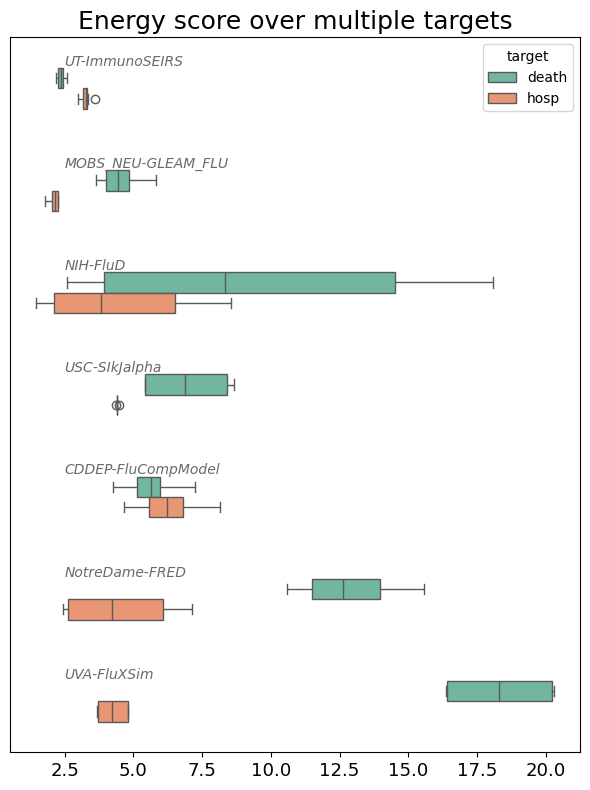

In [13]:
plt.subplots(1,1,figsize=(6,8))
i=1

df = ES_single.copy()


my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index

ges = sns.boxplot(x='energyscore', y='Model', data=df, order = my_order, hue='target', width=0.4, palette='Set2')

ges.set(yticklabels=[])
ges.set(yticks=[])

if i in [1, 3,5]:
    plt.ylabel('', fontsize=15)
else:
    ges.set(ylabel=None)    

if i in [5,6]:
    plt.xlabel('Energy score', fontsize=14)
else:
    ges.set(xlabel=None)


a = 0
for mod in list(my_order):
    plt.text(2.5,a-.22, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.title('Energy score over multiple targets', fontsize=18)
plt.tight_layout()
#plt.savefig('standardrank_energyscore.pdf')
plt.show()


In [35]:
energyscores_mt['target'] = 'multiple targets'
ES_flu_mt = pd.concat([energyscores_mt, ES_single])
#ES_flu_mt = ES_flu_mt[~(ES_flu_mt.Model.isin(['NIH-FluD', 'CDDEP-FluCompModel', 'UVA-FluXSim']))]

In [36]:
ES_flu_mt

,Model,Label,location,energyscore,target
0,CDDEP-FluCompModel,Scenario A,US,8.443649,multiple targets
1,CDDEP-FluCompModel,Scenario B,US,6.281090,multiple targets
2,CDDEP-FluCompModel,Scenario C,US,9.182394,multiple targets
3,CDDEP-FluCompModel,Scenario D,US,7.318083,multiple targets
4,CDDEP-FluCompModel,Scenario E,US,10.853808,multiple targets
...,...,...,...,...,...
43,Trajectory Ensemble,Scenario B,US,1.691712,hosp
44,Trajectory Ensemble,Scenario C,US,2.478263,hosp
45,Trajectory Ensemble,Scenario D,US,1.727563,hosp
46,Trajectory Ensemble,Scenario E,US,2.719265,hosp


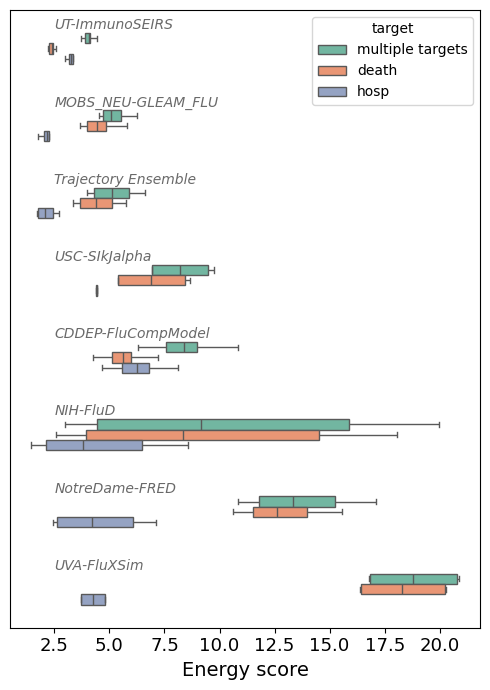

In [39]:
plt.subplots(1,1,figsize=(5,7))
i=1

modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F',
            'NIH-FluD':'Model G', 'CDDEP-FluCompModel':'Model H', 'UVA-FluXSim':'Model I'}
df = ES_flu_mt.copy()


my_order = energyscores_mt.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index

ges = sns.boxplot(x='energyscore', y='Model', data=df, order = my_order, hue='target', width=0.4, palette='Set2',
                 showfliers=False)

ges.set(yticklabels=[])
ges.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('Energy score', fontsize=14)


a = 0
for mod in list(my_order):
    plt.text(2.5,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
#plt.title('Energy score over multiple targets', fontsize=18)
plt.tight_layout()
plt.savefig('../figs/energyscore_multipletargets_flu_models_ens.pdf')
plt.show()


In [40]:
df

,Model,Label,location,energyscore,target
0,CDDEP-FluCompModel,Scenario A,US,8.443649,multiple targets
1,CDDEP-FluCompModel,Scenario B,US,6.281090,multiple targets
2,CDDEP-FluCompModel,Scenario C,US,9.182394,multiple targets
3,CDDEP-FluCompModel,Scenario D,US,7.318083,multiple targets
4,CDDEP-FluCompModel,Scenario E,US,10.853808,multiple targets
...,...,...,...,...,...
43,Trajectory Ensemble,Scenario B,US,1.691712,hosp
44,Trajectory Ensemble,Scenario C,US,2.478263,hosp
45,Trajectory Ensemble,Scenario D,US,1.727563,hosp
46,Trajectory Ensemble,Scenario E,US,2.719265,hosp


# RSV SMH, age groups as multiple targets

In [343]:
def pull_scenario_modeling_hub_predictions(model,date):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    
    for ext in ['.gz.parquet', '.parquet']:
        try:
            predictions = pd.read_parquet(f'../rsvdat/{date}-{model}'+ext)
        except:
            pass
        
    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions


def pull_surveillance_data():
    
    url = f"https://raw.githubusercontent.com/midas-network/rsv-scenario-modeling-hub/main/target-data/2024-07-19_rsvnet_hospitalization.csv"
    return pd.read_csv(url, dtype={'location':str})

In [328]:
observations = pull_surveillance_data()
observations.to_csv('../rsv_hospitalizations_dat.csv')

In [434]:
obs_rsv = pd.read_csv('../rsvdat/rsv_hospitalizations_dat.csv')
obs_rsv = obs_rsv[obs_rsv.target=='inc hosp'].drop(columns=['Unnamed: 0'])

obs_rsv['date'] = pd.to_datetime(obs_rsv['date'])

obs_rsv = obs_rsv[(obs_rsv.date>=pd.to_datetime('2023-11-18')) & (obs_rsv.date<=pd.to_datetime('2024-06-01'))]

In [435]:
newagegroup = pd.DataFrame()
for agegroup in ['0-0.99', '1-4', '5-64']:
    
    if agegroup == '0-0.99':
        sums = ['0-0.49', '0.5-0.99']
    elif agegroup == '1-4':
        sums = ['1-1.99', '2-4']
    else:
        sums = ['5-17', '18-49', '50-64']
        
    for location in obs_rsv.location.unique():
        for date in obs_rsv.date.unique():
            df = obs_rsv[(obs_rsv.location == location) & (obs_rsv.date==date)]
            
            df = df[df.age_group.isin(sums)]
            val = df[df.age_group.isin(sums)].sum()['value']
            
            newrow = pd.DataFrame({'location':location, 'date':date, 'age_group':agegroup, 'target':'inc hosp',
                                  'value':val}, index=[0])
            
            newagegroup = pd.concat([newagegroup, newrow])
        
        
obs = obs_rsv[obs_rsv.age_group.isin(['0-130', '65-130'])].drop(columns = 'population')

observations_reform = pd.concat([newagegroup, obs])

In [486]:
obs_rsv = observations_reform.copy()
obs_rsv = obs_rsv.replace({'value':0}, 1)

In [354]:
date = '2023-11-12'
models = ['CEPH-MetaRSV', 'CU-RSV_SVIRS', 'Ensemble_LOP_all', 'Ensemble_LOP_untrimmed', 'Ensemble_LOP', 
         'Ensemble', 'JHU_UNC-flepiMoP', 'MOBS_NEU-GLEAM_RSV', 'NIH-RSV_MSIRS', 'NIH-RSV_Phenomenological',
         'NIH-RSV_WIN', 'NotreDame-FRED', 'PSI-PROF', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-EpiHiperRSV']

rsvdf = pd.DataFrame()
for model in models:
    df = pull_scenario_modeling_hub_predictions(model,date)
    df['origin_date'] = pd.to_datetime(df['origin_date'])
    df['Model'] = model
    df = df[df.target== 'inc hosp']

    start_end_date = pd.to_datetime('2023-11-18')
    df['target_end_date'] =  df['horizon'].apply(lambda key: start_end_date + \
                                                            timedelta(days = 7)*(key-1))
    
    rsvdf = pd.concat([rsvdf, df])

In [355]:
rsvdf

,origin_date,scenario_id,target,horizon,location,age_group,output_type,output_type_id,value,run_grouping,stochastic_run,Model,target_end_date
0,2023-11-12,A-2023-10-27,inc hosp,1.0,06,0-0.99,sample,NA,132.535560,1.0,1.0,CEPH-MetaRSV,2023-11-18
1,2023-11-12,A-2023-10-27,inc hosp,1.0,06,1-4,sample,NA,48.511100,1.0,1.0,CEPH-MetaRSV,2023-11-18
2,2023-11-12,A-2023-10-27,inc hosp,1.0,06,5-64,sample,NA,34.816985,1.0,1.0,CEPH-MetaRSV,2023-11-18
3,2023-11-12,A-2023-10-27,inc hosp,1.0,06,65-130,sample,NA,53.132920,1.0,1.0,CEPH-MetaRSV,2023-11-18
4,2023-11-12,A-2023-10-27,inc hosp,1.0,06,0-130,sample,NA,268.996565,1.0,1.0,CEPH-MetaRSV,2023-11-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
942495,2023-11-12,E-2023-10-27,inc hosp,25.0,49,0-130,sample,None,64.749076,1.0,99.0,UVA-EpiHiperRSV,2024-05-04
942496,2023-11-12,E-2023-10-27,inc hosp,26.0,49,0-130,sample,None,56.166051,1.0,99.0,UVA-EpiHiperRSV,2024-05-11
942497,2023-11-12,E-2023-10-27,inc hosp,27.0,49,0-130,sample,None,36.583025,1.0,99.0,UVA-EpiHiperRSV,2024-05-18
942498,2023-11-12,E-2023-10-27,inc hosp,28.0,49,0-130,sample,None,54.166051,1.0,99.0,UVA-EpiHiperRSV,2024-05-25


In [520]:
rsv_traj = rsvdf[rsvdf.output_type == 'sample'].drop(columns=['output_type_id'])

rsv_traj['run_grouping'] = rsv_traj['run_grouping'].astype('int32')
rsv_traj['stochastic_run'] = rsv_traj['stochastic_run'].astype('int32')

In [523]:
rsv = pd.DataFrame()
for model in rsv_traj.Model.unique():
    df = rsv_traj[rsv_traj.Model==model]
    if model in ['CEPH-MetaRSV', 'CU-RSV_SVIRS', 'MOBS_NEU-GLEAM_RSV', 'NIH-RSV_MSIRS', 'NIH-RSV_Phenomenological',
                 'NotreDame-FRED', 'UT-ImmunoSEIRS', 'UVA-EpiHiperRSV']:
        df['trajectory_id'] = df['stochastic_run']
        #print(model)
    else:
        print(model)
        df['trajectory_id'] = df['run_grouping']
    rsv = pd.concat([rsv, df])
rsv_traj = rsv.copy()

JHU_UNC-flepiMoP
NIH-RSV_WIN
PSI-PROF
USC-SIkJalpha


In [561]:
energyscores_rsv = pd.DataFrame()
for location in rsv_traj.location.unique():
    for model in rsv_traj.Model.unique():
        for scenario in ['A', 'B', 'C', 'D', 'E']:
            predictions_0_1 = rsv_traj[(rsv_traj.scenario_id == scenario + '-2023-10-27') & \
                                        (rsv_traj.Model == model) &\
                                        (rsv_traj.target_end_date <= obs_rsv.date.max()) & \
                                        (rsv_traj.target_end_date >= obs_rsv.date.min())&\
                                        (rsv_traj.target == 'inc hosp') &\
                                        (rsv_traj.location == location) &\
                                        (rsv_traj.age_group == '0-0.99')]

            X_0_1 = [np.array(predictions_0_1[predictions_0_1.trajectory_id == i].value) for \
                     i in predictions_0_1.trajectory_id.unique()]

            predictions_1_4 = rsv_traj[(rsv_traj.scenario_id == scenario +'-2023-10-27') & \
                                        (rsv_traj.Model == model) &\
                                        (rsv_traj.target_end_date <= obs_rsv.date.max()) & \
                                        (rsv_traj.target_end_date >= obs_rsv.date.min())&\
                                        (rsv_traj.target == 'inc hosp') &\
                                        (rsv_traj.location == location) &\
                                        (rsv_traj.age_group == '1-4')]


            X_1_4 = [np.array(predictions_1_4[predictions_1_4.trajectory_id == i].value) for \
                     i in predictions_1_4.trajectory_id.unique()]


            predictions_5_64 = rsv_traj[(rsv_traj.scenario_id == scenario + '-2023-10-27') & \
                                        (rsv_traj.Model == model) &\
                                        (rsv_traj.target_end_date <= obs_rsv.date.max()) & \
                                        (rsv_traj.target_end_date >= obs_rsv.date.min())&\
                                        (rsv_traj.target == 'inc hosp') &\
                                        (rsv_traj.location == location) &\
                                        (rsv_traj.age_group == '5-64')]


            X_5_64 = [np.array(predictions_5_64[predictions_5_64.trajectory_id == i].value) for \
                     i in predictions_5_64.trajectory_id.unique()]


            predictions_65_130 = rsv_traj[(rsv_traj.scenario_id == scenario + '-2023-10-27') & \
                                        (rsv_traj.Model == model) &\
                                        (rsv_traj.target_end_date <= obs_rsv.date.max()) & \
                                        (rsv_traj.target_end_date >= obs_rsv.date.min())&\
                                        (rsv_traj.target == 'inc hosp') &\
                                        (rsv_traj.location == location) &\
                                        (rsv_traj.age_group == '65-130')]


            X_65_130 = [np.array(predictions_65_130[predictions_65_130.trajectory_id == i].value) for \
                     i in predictions_65_130.trajectory_id.unique()]



            A = []

            for i in range(len(X_0_1)):
                Ai = np.array([X_0_1[i], X_1_4[i], X_5_64[i], X_65_130[i]])
                A.append(Ai)

            A = np.array(A)
            
            # format observations
            obs = obs_rsv[obs_rsv.location == location]
            obs_0_1 = np.array(obs[obs.age_group=='0-0.99']['value'])
            obs_1_4 = np.array(obs[obs.age_group=='1-4']['value'])
            obs_5_64 = np.array(obs[obs.age_group=='5-64']['value'])
            obs_65_130 = np.array(obs[obs.age_group=='65-130']['value'])
            obs = np.array([obs_0_1, obs_1_4, obs_5_64, obs_65_130])


            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':location,  
                                 'energyscore': ES}, index=[0])

            energyscores_rsv = pd.concat([energyscores_rsv, newrow])

energyscores_rsv = energyscores_rsv.reset_index().drop(columns=['index'])   


In [562]:
energyscores_rsv

,Model,Label,location,energyscore
0,CEPH-MetaRSV,Scenario A,06,324.676318
1,CEPH-MetaRSV,Scenario B,06,332.338027
2,CEPH-MetaRSV,Scenario C,06,337.447888
3,CEPH-MetaRSV,Scenario D,06,345.228448
4,CEPH-MetaRSV,Scenario E,06,356.026927
...,...,...,...,...
775,UVA-EpiHiperRSV,Scenario A,US,2575.667128
776,UVA-EpiHiperRSV,Scenario B,US,2531.508979
777,UVA-EpiHiperRSV,Scenario C,US,2504.369509
778,UVA-EpiHiperRSV,Scenario D,US,2516.295554


In [563]:
energyscores_rsv.to_pickle('../rsvdat/energyscore_mt_rsv.pkl')

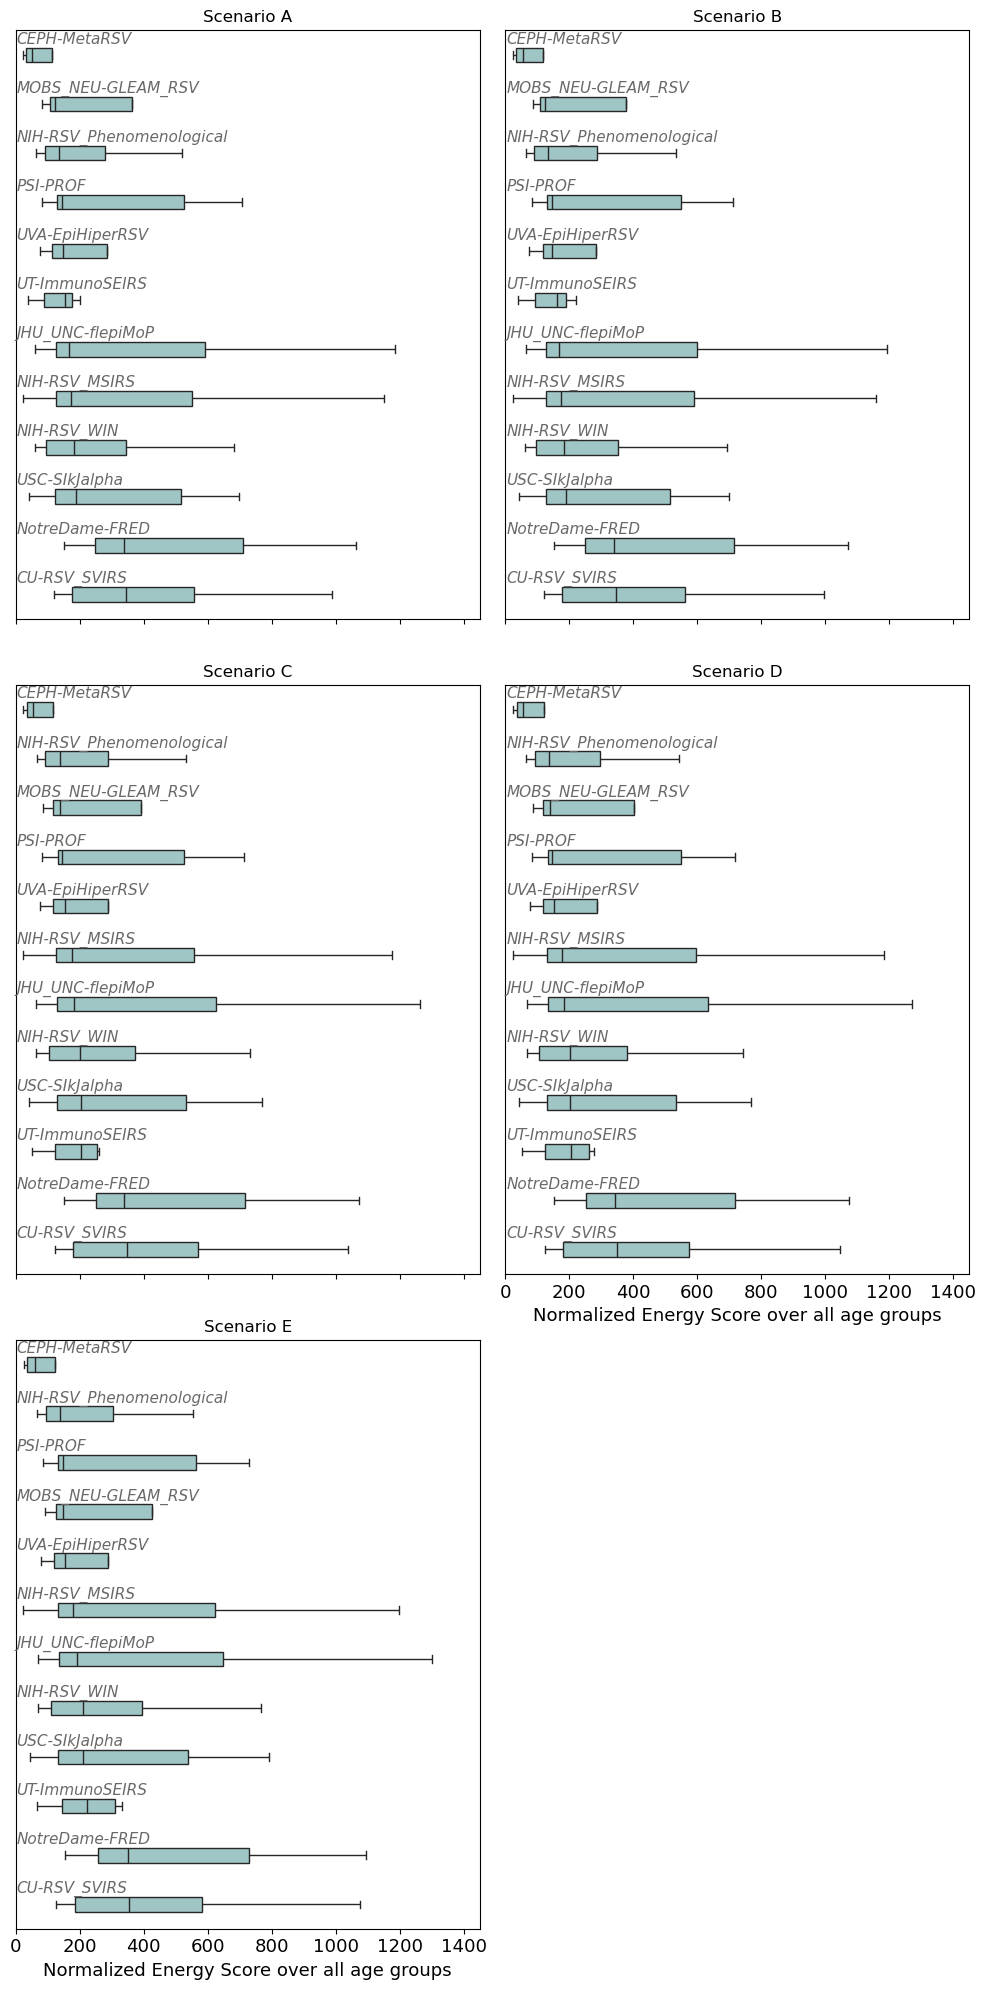

In [632]:
fig, ax = plt.subplots(3,2,figsize=(10,20))
i=1
fig.delaxes(ax[2][1])
df = energyscores_rsv.copy()

for scenario in df.Label.unique():
    axs = plt.subplot(3,2,i)
    d = df[df.Label==scenario]

    my_order = d.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index

    ges = sns.boxplot(x='energyscore', y='Model', data=d, order = my_order, color = 'teal', width=0.3, 
                      showfliers=False)
    
    for patch in axs.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .4))


   # sns.swarmplot(x='energyscore', y='Model', data=d,order=my_order,color = "teal",
    #              alpha = .85,size=1.5, orient="h")    


    ges.set(yticklabels=[])
    ges.set(yticks=[])
    ges.set(ylabel=None)
    ges.set(xlabel=None)
    ges.set(xticklabels=[])
    ges.set(xticks=[0, 200, 400, 600, 800, 1000, 1200, 1400])
    plt.xlim([0,1450])

    if i in [4,5]:
        plt.xlabel('Normalized Energy Score over all age groups', fontsize=13)
        ges.set(xticks=[0, 200, 400, 600, 800, 1000, 1200, 1400])
        ges.set(xticklabels=[0, 200, 400, 600, 800, 1000, 1200, 1400])


    a = 0
    for mod in list(my_order):
        plt.text(2.5,a-.23, mod, fontsize=11, style='italic', color='dimgray')
        a+=1

    plt.xticks(fontsize=13)
    plt.title(scenario)
    i+=1
#plt.title('Energy score over multiple targets', fontsize=18)
plt.tight_layout()
plt.savefig('../figs/rsv_multipletargets_ES.pdf')
plt.show()



In [570]:
ES_agegroups = pd.DataFrame()
for agegroup in ['0-0.99', '1-4', '5-64', '65-130', '0-130']:
    df = pd.DataFrame()
    for location in rsv_traj.location.unique():
        for model in rsv_traj.Model.unique():
            for scenario in ['A', 'B', 'C', 'D', 'E']:
                predictions_0_1 = rsv_traj[(rsv_traj.scenario_id == scenario + '-2023-10-27') & \
                                            (rsv_traj.Model == model) &\
                                            (rsv_traj.target_end_date <= obs_rsv.date.max()) & \
                                            (rsv_traj.target_end_date >= obs_rsv.date.min())&\
                                            (rsv_traj.target == 'inc hosp') &\
                                            (rsv_traj.location == location) &\
                                            (rsv_traj.age_group == agegroup)]

                X_0_1 = [np.array(predictions_0_1[predictions_0_1.trajectory_id == i].value) for \
                         i in predictions_0_1.trajectory_id.unique()]


                A = []

                for i in range(len(X_0_1)):
                    Ai = np.array([X_0_1[i]])
                    A.append(Ai)

                A = np.array(A)

                # format observations
                obs = obs_rsv[obs_rsv.location == location]
                obs_0_1 = np.array(obs[obs.age_group==agegroup]['value'])
                obs = np.array([obs_0_1])


                ES = energyscore_multipletargets(A,obs)


                newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':location,
                                      'age_group':agegroup  ,'energyscore': ES}, index=[0])

                df = pd.concat([df, newrow])

    df = df.reset_index().drop(columns=['index'])   
    ES_agegroups = pd.concat([ES_agegroups, df])


ValueError: unable to broadcast argument 1 to output array
File "/var/folders/tc/9lbjwrhx1dv0_0vb1_v_4q6r0000gp/T/ipykernel_91651/1549399023.py", line 1, 

In [572]:
ES_agegroupsold = ES_agegroups

In [583]:
ES_agegroups.to_pickle('../rsvdat/energyscore_agegroups_rsv.pkl')

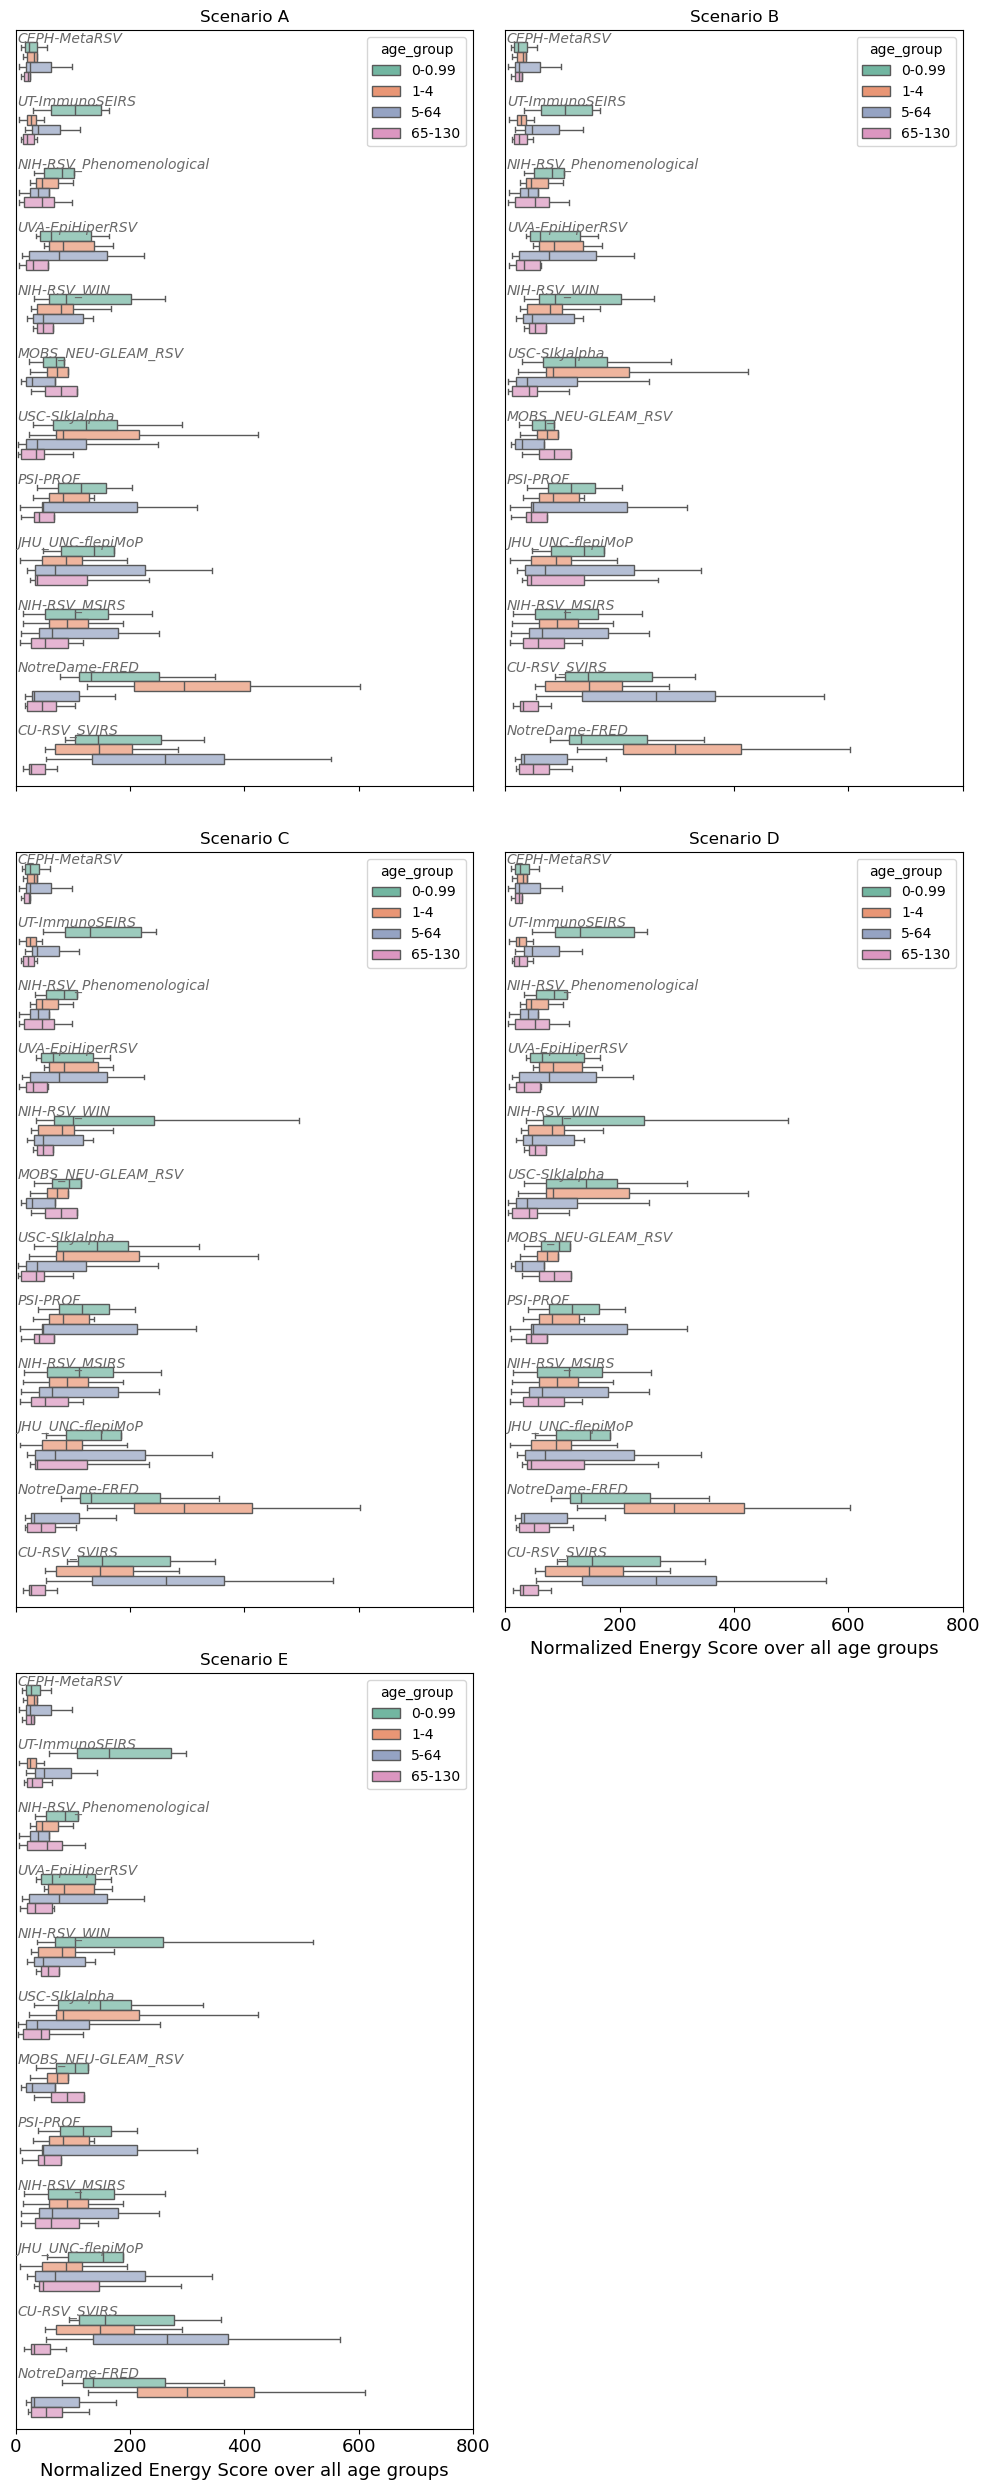

In [630]:
fig, ax = plt.subplots(3,2,figsize=(10,25))
i=1
fig.delaxes(ax[2][1])
df = ES_agegroups.copy()
df = df[~df.age_group.isin(['0-130'])]

for scenario in df.Label.unique():
    axs = plt.subplot(3,2,i)
    d = df[df.Label==scenario]

    my_order = d.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index

    ges = sns.boxplot(x='energyscore', y='Model', data=d, order = my_order, hue='age_group', width=0.62, 
                      showfliers=False, palette='Set2')
    
    for patch in axs.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .7))


   # sns.swarmplot(x='energyscore', y='Model', data=d,order=my_order,color = "teal",
    #              alpha = .85,size=1.5, orient="h")    


    ges.set(yticklabels=[])
    ges.set(yticks=[])
    ges.set(ylabel=None)
    ges.set(xlabel=None)
    ges.set(xticklabels=[])
    ges.set(xticks=[0, 200, 400, 600, 800])
    plt.xlim([0,800])

    if i in [4,5]:
        plt.xlabel('Normalized Energy Score over all age groups', fontsize=13)
        ges.set(xticks=[0, 200, 400, 600, 800])
        ges.set(xticklabels=[0, 200, 400, 600, 800])


    a = 0
    for mod in list(my_order):
        plt.text(2.5,a-.3, mod, fontsize=10, style='italic', color='dimgray')
        a+=1

    plt.xticks(fontsize=13)
    plt.title(scenario)
    i+=1
#plt.title('Energy score over multiple targets', fontsize=18)
plt.tight_layout()
plt.savefig('../figs/rsv_agegroups_ES.pdf')
plt.show()



In [584]:
ES_agegroups

,Model,Label,location,age_group,energyscore
0,CEPH-MetaRSV,Scenario A,06,0-0.99,215.468927
1,CEPH-MetaRSV,Scenario B,06,0-0.99,216.272390
2,CEPH-MetaRSV,Scenario C,06,0-0.99,234.362362
3,CEPH-MetaRSV,Scenario D,06,0-0.99,235.226090
4,CEPH-MetaRSV,Scenario E,06,0-0.99,242.724510
...,...,...,...,...,...
775,UVA-EpiHiperRSV,Scenario A,US,0-130,43.637267
776,UVA-EpiHiperRSV,Scenario B,US,0-130,44.468959
777,UVA-EpiHiperRSV,Scenario C,US,0-130,43.518071
778,UVA-EpiHiperRSV,Scenario D,US,0-130,44.516693


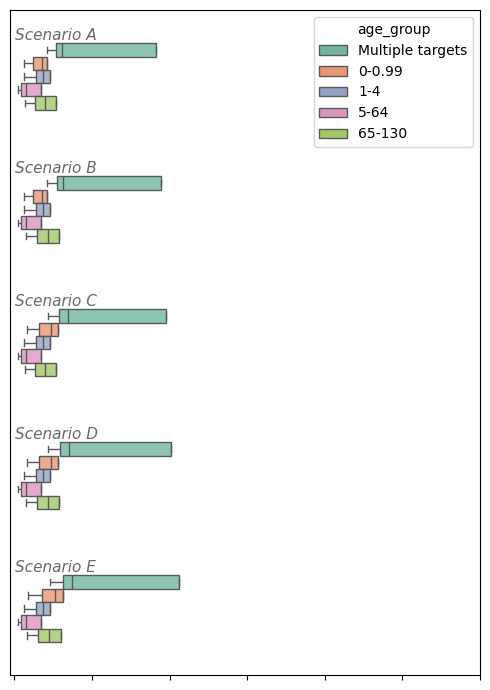

In [634]:
fig, ax = plt.subplots(1,1,figsize=(5,7))
i=1


df = energyscores_rsv.copy()
df_mt = df[df.Model == 'MOBS_NEU-GLEAM_RSV']
df_mt['age_group'] = 'Multiple targets'

df = ES_agegroups.copy()
df_ag = df[(~df.age_group.isin(['0-130'])) & (df.Model == 'MOBS_NEU-GLEAM_RSV')]

df = pd.concat([df_mt, df_ag])



d = df.copy()

my_order = d.groupby(by=["Label"])["energyscore"].median().sort_values(ascending=True).index

ges = sns.boxplot(x='energyscore', y='Label', data=d, order = my_order, hue='age_group', width=0.5, 
                  showfliers=False, palette='Set2')

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .8))


# sns.swarmplot(x='energyscore', y='Model', data=d,order=my_order,color = "teal",
#              alpha = .85,size=1.5, orient="h")    


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
ges.set(xlabel=None)
ges.set(xticklabels=[])
ges.set(xticks=[0, 200, 400, 600, 800, 1000, 1200])
# plt.xlim([0,1250])

if i in [4,5]:
    plt.xlabel('Normalized Energy Score over all age groups', fontsize=13)
    ges.set(xticks=[0, 200, 400, 600, 800, 1000, 1200])
    ges.set(xticklabels=[0, 200, 400, 600, 800, 1000, 1200])


a = 0
for mod in list(my_order):
    plt.text(2.5,a-.275, mod, fontsize=11, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)

#plt.title('Energy score over multiple targets', fontsize=18)
plt.tight_layout()
#plt.savefig('../figs/rsv_multipletargets_ES.pdf')
plt.show()


In [637]:
df_mt

,Model,Label,location,energyscore,age_group
15,MOBS_NEU-GLEAM_RSV,Scenario A,06,1009.108746,Multiple targets
16,MOBS_NEU-GLEAM_RSV,Scenario B,06,1056.759665,Multiple targets
17,MOBS_NEU-GLEAM_RSV,Scenario C,06,1133.617205,Multiple targets
18,MOBS_NEU-GLEAM_RSV,Scenario D,06,1176.106002,Multiple targets
19,MOBS_NEU-GLEAM_RSV,Scenario E,06,1263.539658,Multiple targets
...,...,...,...,...,...
735,MOBS_NEU-GLEAM_RSV,Scenario A,US,2253.602669,Multiple targets
736,MOBS_NEU-GLEAM_RSV,Scenario B,US,2252.908648,Multiple targets
737,MOBS_NEU-GLEAM_RSV,Scenario C,US,2254.725177,Multiple targets
738,MOBS_NEU-GLEAM_RSV,Scenario D,US,2254.031553,Multiple targets


In [640]:
df_ag.groupby(by=['Model', 'Label', 'location']).sum().to_csv('../rsvdat/energyscore_agegroups_sum.csv')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


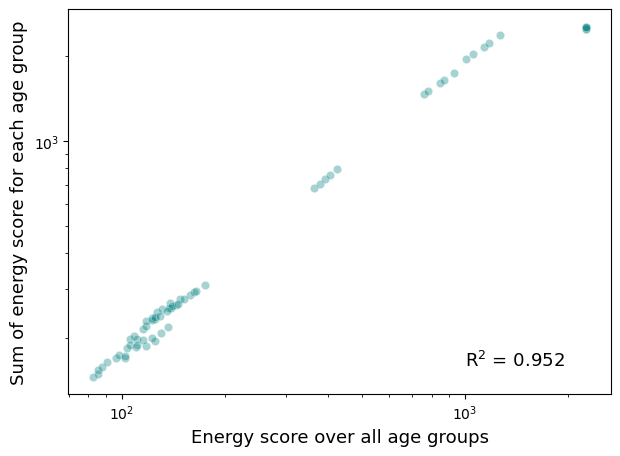

In [678]:

plt.figure(figsize=(7,5))
df_ag_sum = pd.read_csv('../rsvdat/energyscore_agegroups_sum.csv').rename(columns={'energyscore':'energyscore_sum'})
df_all = df_mt.merge(df_ag_sum, on=['Model', 'Label', 'location'])

sns.scatterplot(x='energyscore', y='energyscore_sum',data=df_all ,color='teal', alpha=.35)

plt.xlabel('Energy score over all age groups', fontsize=13)
plt.ylabel('Sum of energy score for each age group', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(df_all.energyscore, 
                                                         df_all.energyscore_sum)

    
plt.text(1000,160, r'R$^2$ = '+str(round(r_value, 3)), fontsize=13)
plt.xscale('log')
plt.yscale('log')

In [5]:
modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F',
            'NIH-FluD':'Model G', 'CDDEP-FluCompModel':'Model H', 'UVA-FluXSim':'Model I'}

# Multitarget pairing sensitivity analysis

In [6]:
# use Flu SMH data and shuffle trajectory matrices for hosp and death nationally and calculate energy score
# for different matrix formulations

In [14]:
# surveillance data

#deaths
deaths = pd.read_csv('../fludat/National_2023-24_Data.csv').drop(columns=['SUB AREA', 'AGE GROUP', 
                                                                    'PERCENT COMPLETE', 'TOTAL DEATHS'])

deaths['YEAR'] = deaths['WEEK'].apply(lambda key: 2023 if key>=30 else 2024)
deaths['date'] = deaths['WEEK'].apply(lambda key: Week(2023, key).enddate() if key>=30 else Week(2024, 
                                                                                         key).enddate())

deaths = deaths[deaths.date<=pd.to_datetime('2024-04-27')]


#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.location=='US') & (hosp.date>=pd.to_datetime('2023-10-01'))].sort_values(by=['date']).drop(columns=\
                                                                               'Unnamed: 0').reset_index()

h = np.array(hosp['value'])
d = np.array(deaths['NUM INFLUENZA DEATHS'])
obs = np.array([h,d])

In [10]:
# include all models, even those only submitting for one location
modelsall = ['MOBS_NEU-GLEAM_FLU']

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(hosp.date.max())


predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pull_flu_scenario_modeling_hub_predictions(model,'2023-09-03')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    
    numweeks = list(df.horizon.unique())
    start_date = list(df.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates}) # add date of prediction to dataframe
    df = df.merge(dfdates, how='inner', on='horizon')

    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
    

In [11]:
predictionsUS = predictionsall[predictionsall.location=='US']
#predictionsUS = predictionsUS[~predictionsUS['Model'].isin(['NIH-Flu_TS', 'PSI-M2'])]

In [12]:
predictionsUS

,origin_date,scenario_id,target,horizon,location,age_group,output_type,output_type_id,value,Model,trajectory_id,target_end_date
5100,2023-09-03,A-2023-08-14,inc hosp,1,US,0-130,sample,1,579.000,MOBS_NEU-GLEAM_FLU,1,2023-09-09
5101,2023-09-03,A-2023-08-14,inc hosp,1,US,0-130,sample,2,579.000,MOBS_NEU-GLEAM_FLU,2,2023-09-09
5102,2023-09-03,A-2023-08-14,inc hosp,1,US,0-130,sample,3,570.000,MOBS_NEU-GLEAM_FLU,3,2023-09-09
5103,2023-09-03,A-2023-08-14,inc hosp,1,US,0-130,sample,4,669.000,MOBS_NEU-GLEAM_FLU,4,2023-09-09
5104,2023-09-03,A-2023-08-14,inc hosp,1,US,0-130,sample,5,623.000,MOBS_NEU-GLEAM_FLU,5,2023-09-09
...,...,...,...,...,...,...,...,...,...,...,...,...
1081195,2023-09-03,F-2023-08-14,inc death,34,US,0-130,sample,96,61.162,MOBS_NEU-GLEAM_FLU,96,2024-04-27
1081196,2023-09-03,F-2023-08-14,inc death,34,US,0-130,sample,97,39.240,MOBS_NEU-GLEAM_FLU,97,2024-04-27
1081197,2023-09-03,F-2023-08-14,inc death,34,US,0-130,sample,98,53.497,MOBS_NEU-GLEAM_FLU,98,2024-04-27
1081198,2023-09-03,F-2023-08-14,inc death,34,US,0-130,sample,99,11.591,MOBS_NEU-GLEAM_FLU,99,2024-04-27


In [31]:
model = 'MOBS_NEU-GLEAM_FLU'
energyscores_mt = pd.DataFrame()
for it in range(100):
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

        predictionshosp = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                    (predictionsUS.target_end_date <= hosp.date.max()) & \
                                    (predictionsUS.target_end_date >= hosp.date.min())&\
                                    (predictionsUS.Model == model) &\
                                    (predictionsUS.target == 'inc hosp')  ]

        newid = random.sample(list(predictionshosp['trajectory_id']), k=len(list(predictionshosp['trajectory_id'])))
        predictionshosp['new_id'] = newid

        Xhosp = [np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                 i in predictionshosp.new_id.unique()]


        predictionsdeath = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                    (predictionsUS.target_end_date <= hosp.date.max()) & \
                                    (predictionsUS.target_end_date >= hosp.date.min())&\
                                    (predictionsUS.Model == model) &\
                                    (predictionsUS.target == 'inc death')  ]

        newid = random.sample(list(predictionsdeath['trajectory_id']), k=len(list(predictionsdeath['trajectory_id'])))
        predictionsdeath['new_id'] = newid

        Xdeath = [np.array(predictionsdeath[predictionsdeath.new_id == i].value) for \
                 i in predictionsdeath.new_id.unique()]


        A = []

        for i in range(len(Xhosp)):
            Ai = np.array([Xhosp[i], Xdeath[i]])
            A.append(Ai)

        A = np.array(A)

        ES = energyscore_multipletargets(A,obs)


        newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                             'energyscore': ES, 'it':it}, index=[0])

        energyscores_mt = pd.concat([energyscores_mt, newrow])

energyscores_mt = energyscores_mt.reset_index().drop(columns=['index'])  

In [32]:
energyscores_mt

,Model,Label,location,energyscore,it
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,4.403987,0
1,MOBS_NEU-GLEAM_FLU,Scenario B,US,7.755438,0
2,MOBS_NEU-GLEAM_FLU,Scenario C,US,4.556185,0
3,MOBS_NEU-GLEAM_FLU,Scenario D,US,6.105531,0
4,MOBS_NEU-GLEAM_FLU,Scenario E,US,5.413334,0
...,...,...,...,...,...
595,MOBS_NEU-GLEAM_FLU,Scenario B,US,7.866095,99
596,MOBS_NEU-GLEAM_FLU,Scenario C,US,4.617243,99
597,MOBS_NEU-GLEAM_FLU,Scenario D,US,5.898268,99
598,MOBS_NEU-GLEAM_FLU,Scenario E,US,5.278112,99


Text(0.5, 0, 'Energy score over multiple targets')

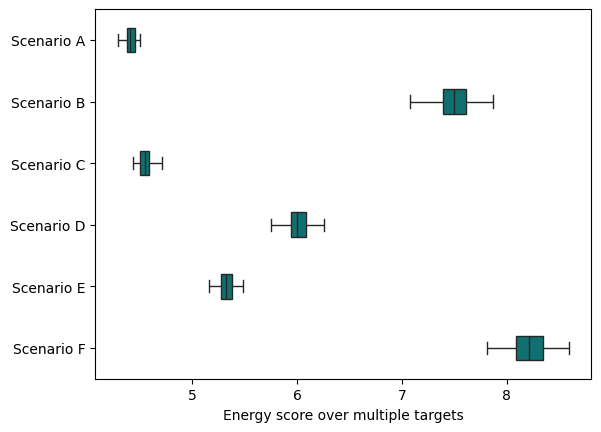

In [35]:
# just for MOBS model
sns.boxplot(x='energyscore', y='Label', data=energyscores_mt, width=.4, showfliers=False, color='teal')
plt.ylabel('')
plt.xlabel('Energy score over multiple targets')

In [ ]:
# do for all models

In [37]:
# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(hosp.date.max())




predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pull_flu_scenario_modeling_hub_predictions(model,'2023-09-03')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    
    numweeks = list(df.horizon.unique())
    start_date = list(df.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates}) # add date of prediction to dataframe
    df = df.merge(dfdates, how='inner', on='horizon')

    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
    
predictionsUS = predictionsall[predictionsall.location=='US']


In [44]:

energyscores_mt = pd.DataFrame()
for it in range(100):
    for model in ['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim',
                 'NIH-FluD', 'CDDEP-FluCompModel']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            predictionshosp = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.Model == model) &\
                                        (predictionsUS.target == 'inc hosp')  ]

            newid = random.sample(list(predictionshosp['trajectory_id']), k=len(list(predictionshosp['trajectory_id'])))
            predictionshosp['new_id'] = newid

            Xhosp = [np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                     i in predictionshosp.new_id.unique()]


            predictionsdeath = predictionsUS[(predictionsUS.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsUS.target_end_date <= hosp.date.max()) & \
                                        (predictionsUS.target_end_date >= hosp.date.min())&\
                                        (predictionsUS.Model == model) &\
                                        (predictionsUS.target == 'inc death')  ]

            newid = random.sample(list(predictionsdeath['trajectory_id']), k=len(list(predictionsdeath['trajectory_id'])))
            predictionsdeath['new_id'] = newid

            Xdeath = [np.array(predictionsdeath[predictionsdeath.new_id == i].value) for \
                     i in predictionsdeath.new_id.unique()]


            A = []

            for i in range(len(Xhosp)):
                Ai = np.array([Xhosp[i], Xdeath[i]])
                A.append(Ai)

            A = np.array(A)

            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_mt = pd.concat([energyscores_mt, newrow])

energyscores_mt = energyscores_mt.reset_index().drop(columns=['index'])  

In [45]:
energyscores_mt

,Model,Label,location,energyscore,it
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,4.388984,0
1,MOBS_NEU-GLEAM_FLU,Scenario B,US,7.515197,0
2,MOBS_NEU-GLEAM_FLU,Scenario C,US,4.580801,0
3,MOBS_NEU-GLEAM_FLU,Scenario D,US,5.853257,0
4,MOBS_NEU-GLEAM_FLU,Scenario E,US,5.430086,0
...,...,...,...,...,...
4195,CDDEP-FluCompModel,Scenario B,US,5.340896,99
4196,CDDEP-FluCompModel,Scenario C,US,7.775364,99
4197,CDDEP-FluCompModel,Scenario D,US,6.096946,99
4198,CDDEP-FluCompModel,Scenario E,US,9.489461,99


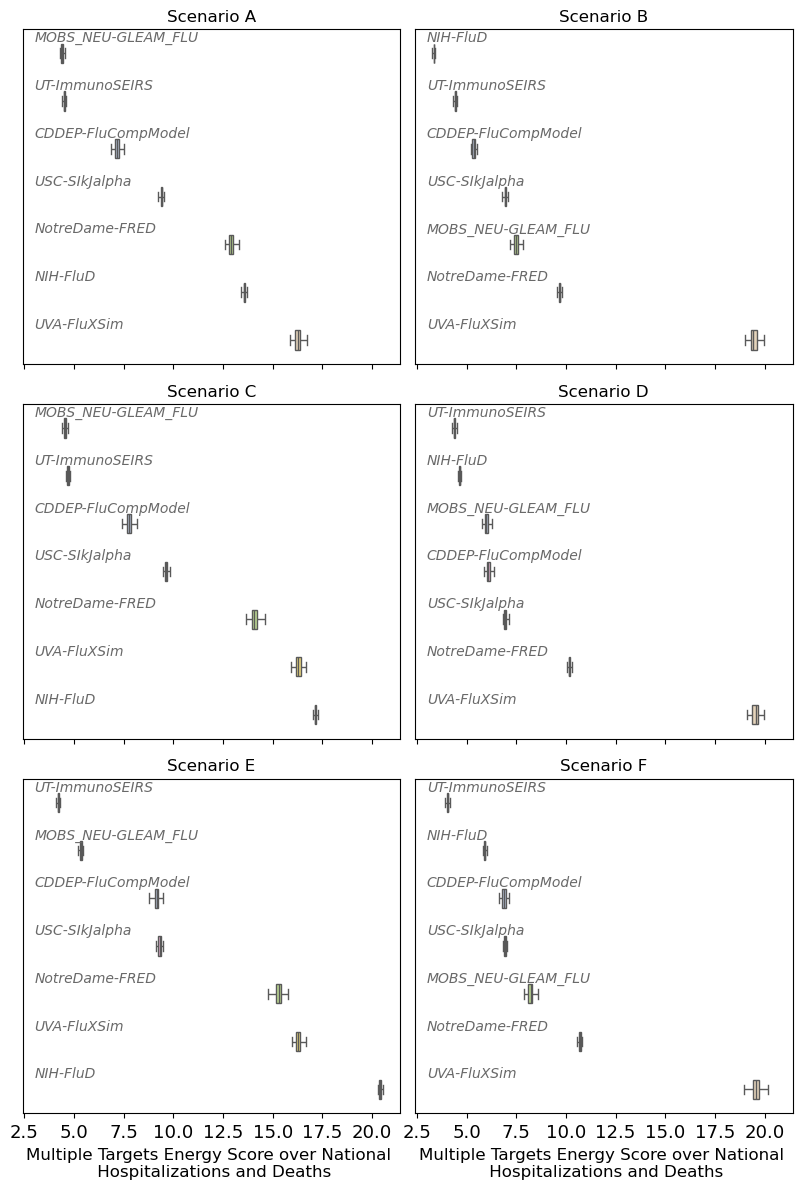

In [68]:
fig, ax = plt.subplots(3,2,figsize=(8,12), sharex=True)
i=1

for scenario in energyscores_mt.Label.unique():
    axs = plt.subplot(3,2,i)
    d = energyscores_mt[energyscores_mt.Label==scenario]

    my_order = d.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index

    ges = sns.boxplot(x='energyscore', y='Model', data=d, order = my_order,width=0.4, 
                      showfliers=False, palette='Set2')
    
    for patch in axs.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .7))


   # sns.swarmplot(x='energyscore', y='Model', data=d,order=my_order,color = "teal",
    #              alpha = .85,size=1.5, orient="h")    


    ges.set(yticklabels=[])
    ges.set(yticks=[])
    ges.set(ylabel=None)
    ges.set(xlabel=None)
    #ges.set(xticklabels=[])
    #ges.set(xticks=[2.5, 5, 10, 15, 20])
    #plt.xlim([0,800])

    if i in [5,6]:
        plt.xlabel('Multiple Targets Energy Score over National \n Hospitalizations and Deaths', fontsize=12)
        #ges.set(xticks=[2.5, 5, 10, 15, 20])
        #ges.set(xticklabels=[2.5, 5, 10, 15, 20])


    a = 0
    for mod in list(my_order):
        plt.text(3,a-.25, mod, fontsize=10, style='italic', color='dimgray')
        a+=1

    plt.xticks(fontsize=13)
    plt.title(scenario)
    i+=1
#plt.title('Energy score over multiple targets', fontsize=18)
plt.tight_layout()
#plt.savefig('../figs/rsv_agegroups_ES.pdf')
plt.show()



In [ ]:
# try for MOBS for all states, just hospitalizations to get more dimensions

In [79]:
dfmobs = predictionsall[(predictionsall.Model=='MOBS_NEU-GLEAM_FLU') & (predictionsall.target=='inc hosp')]

In [189]:
#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-11-18'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]
#h = np.array(hosp['value'])
#obs = np.array([h,d])

In [155]:
hosp

,date,location,location_name,value
0,2023-11-25,56,Wyoming,23
1,2023-11-25,26,Michigan,88
2,2023-11-25,23,Maine,9
3,2023-11-25,24,Maryland,22
4,2023-11-25,25,Massachusetts,51
...,...,...,...,...
1214,2024-04-27,33,New Hampshire,4
1215,2024-04-27,31,Nebraska,17
1216,2024-04-27,38,North Dakota,7
1217,2024-04-27,44,Rhode Island,7


In [156]:
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

In [160]:

energyscores_locations = pd.DataFrame()
for it in range(100):
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in locations:
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [161]:
energyscores_locations

,Model,Label,location,energyscore,it
0,MOBS_NEU-GLEAM_FLU,Scenario A,US,21.729432,0
1,MOBS_NEU-GLEAM_FLU,Scenario B,US,21.516345,0
2,MOBS_NEU-GLEAM_FLU,Scenario C,US,25.244717,0
3,MOBS_NEU-GLEAM_FLU,Scenario D,US,23.521440,0
4,MOBS_NEU-GLEAM_FLU,Scenario E,US,26.524178,0
...,...,...,...,...,...
595,MOBS_NEU-GLEAM_FLU,Scenario B,US,21.445906,99
596,MOBS_NEU-GLEAM_FLU,Scenario C,US,25.637189,99
597,MOBS_NEU-GLEAM_FLU,Scenario D,US,23.680182,99
598,MOBS_NEU-GLEAM_FLU,Scenario E,US,26.315538,99


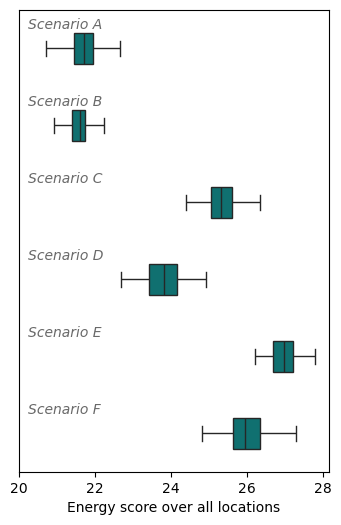

In [333]:
# just for MOBS model
fig, ax = plt.subplots(1,1,figsize=(4,6), sharex=True)

my_order = list(energyscores_locations.Label.unique())
sns.boxplot(x='energyscore', y='Label', data=energyscores_locations, width=.4, showfliers=False, color='teal')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Energy score over all locations')

a=0
for mod in list(my_order):
    plt.text(20.25,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks([20, 22, 24, 26, 28])

plt.savefig('../figs/mulitargets_locations_MOBS.pdf')

([<matplotlib.axis.YTick at 0x7fc873b3cbe0>,
 [Text(0, 20, '20'),
  Text(0, 22, '22'),
  Text(0, 24, '24'),
  Text(0, 26, '26'),
  Text(0, 28, '28')])

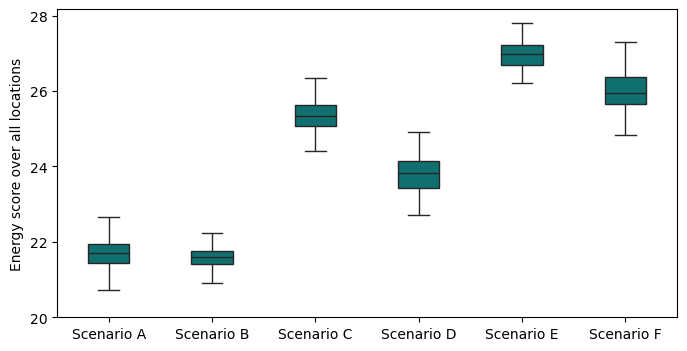

In [344]:
fig, ax = plt.subplots(1,1,figsize=(8,4), sharex=True)

my_order = list(energyscores_locations.Label.unique())
sns.boxplot(y='energyscore', x='Label', data=energyscores_locations, width=.4, showfliers=False, color='teal')
plt.xlabel('')
#plt.yticks([])
plt.ylabel('Energy score over all locations')

a=0
for mod in list(my_order):
   # plt.text(20.25,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.yticks([20, 22, 24, 26, 28])
#plt.tight_layout()

In [163]:
dfall = predictionsall[(predictionsall.target=='inc hosp')]

In [271]:
energyscores_locall = pd.DataFrame()
for it in range(100):
    print(it)
    for model in ['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'USC-SIkJalpha', 'UT-ImmunoSEIRS',
                  'NIH-Flu_TS', 'PSI-M2']:
        #print(model)
        for scenario in ['D']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66', '69','60', '78']:
                    continue
                predictionshosp = dfall[(dfall.scenario_id == scenario + '-2023-08-14') & \
                                            (dfall.target_end_date <= hosp.date.max()) & \
                                            (dfall.target_end_date >= hosp.date.min())&\
                                            (dfall.Model == model) &\
                                            (dfall.location==loc)]
                hospfilt = hosp[hosp.location.isin(dfall[dfall.Model==model].location.unique())]
                obsnew = np.array([np.array(hospfilt[hospfilt.location == i].value) for \
                     i in hospfilt.location.unique()])
                

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid
                
                if len(predictionshosp)==0:
                    continue

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in loc_array.keys():
                    if loc in ['72', '66']:
                        continue
                    if len(loc_array[loc]) ==0:
                        continue
                        
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            C = np.array(A)



            ES = energyscore_multipletargets(C,obsnew)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locall = pd.concat([energyscores_locall, newrow])

energyscores_locall = energyscores_locall.reset_index().drop(columns=['index'])  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [272]:
energyscores_locall.to_pickle('../fludat/energyscore_mt_locations_scenD_101.pkl')

In [273]:
energyscores_locall

,Model,Label,energyscore,it
0,MOBS_NEU-GLEAM_FLU,Scenario D,24.172093,0
1,NotreDame-FRED,Scenario D,80.541757,0
2,USC-SIkJalpha,Scenario D,32.212616,0
3,UT-ImmunoSEIRS,Scenario D,206.891566,0
4,NIH-Flu_TS,Scenario D,15.370926,0
...,...,...,...,...
595,NotreDame-FRED,Scenario D,82.186272,99
596,USC-SIkJalpha,Scenario D,31.873464,99
597,UT-ImmunoSEIRS,Scenario D,208.393589,99
598,NIH-Flu_TS,Scenario D,15.600847,99


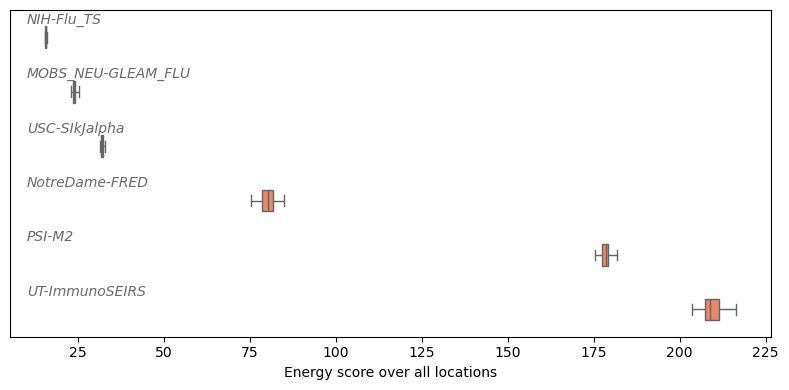

In [343]:
fig, ax = plt.subplots(1,1,figsize=(8,4), sharex=True)

#df= energyscores_locall

my_order = energyscores_locall.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=energyscores_locall, width=.4,order=my_order, 
            showfliers=False, color='coral')
plt.ylabel('')
plt.xlabel('Energy score over all locations')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[2.5, 5, 10, 15, 20])
#plt.xlim([0,800])

a = 0
for mod in list(my_order):
    plt.text(10,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')

#plt.xlim([0,100])
plt.tight_layout()

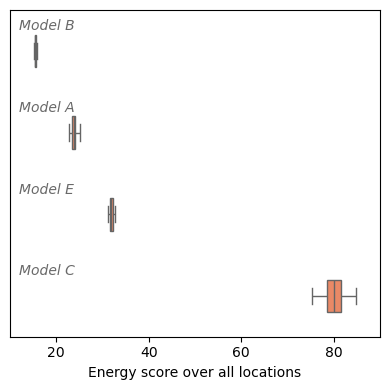

In [332]:
fig, ax = plt.subplots(1,1,figsize=(4,4), sharex=True)

df= energyscores_locall[(energyscores_locall.Model != 'PSI-M2') & (energyscores_locall.Model != 'UT-ImmunoSEIRS')]

my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, color='coral')
plt.ylabel('')
plt.xlabel('Energy score over all locations')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[20, 40, 60, 80])
plt.xlim([10,90])

a = 0
for mod in list(my_order):
    plt.text(12,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')
plt.xticks([20, 40, 60, 80])

#plt.xlim([0,100])

plt.tight_layout()

plt.savefig('../figs/multitarget_locations_A.pdf')

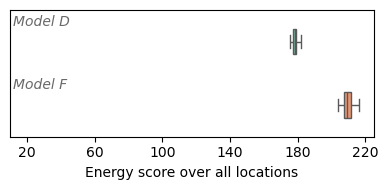

In [330]:
fig, ax = plt.subplots(1,1,figsize=(4,2), sharex=True)

df= energyscores_locall[(energyscores_locall.Model.isin(['PSI-M2', 'UT-ImmunoSEIRS'])) ]

my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, palette='Set2')
plt.ylabel('')
plt.xlabel('Energy score over all locations')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[20, 40, 60, 80])
plt.xlim([10,225])

a = 0
for mod in list(my_order):
    plt.text(12,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')
plt.xticks([20, 60, 100, 140, 180, 220])

#plt.xlim([0,100])

plt.tight_layout()
plt.savefig('../figs/multitarget_locations_B.pdf')

plt.show()